# Introduction to pathway analysis in metabolomics

<b>This pathway analysis tutorial forms part of the Hands-on Data Analysis for Metabolic Profiling course at Imperial College London.</b>

The topics that are covered in this tutorial are:
- Compound ID mapping
- Over-representation analysis
- Gene set enrichment analysis in metabolomics
- Pathway database choice
- Additional exercise: pathway visualisation

You should not focus on understanding every line of code in this tutorial, but rather it should help provide an overview of the key concepts in metabolomics pathway analysis.

Please make sure you run each cell in order to ensure the code works correctly. 

### Data import
All pathway analysis methods require at least a dataset and a set of pathways. First we are going to import the KEGG human pathways and the processed metabolomics dataset we will be working with. It is important to ensure the data has been processed prior to pathway analysis. This includes:
1. Sample normalisation (e.g. Probabilistic Quotient Normalisation)
2. Missing value imputation
3. Log transformation
4. Centering and scaling the features to mean = 0 and standard deviation = 1
5. Outlier detection (e.g. using PCA)

For more details about pre-processing metabolomics data, see here: https://www.intechopen.com/books/metabolomics-fundamentals-and-applications/processing-and-visualization-of-metabolomics-data-using-r


In [ ]:
# Import the required packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from sklearn.decomposition import PCA

In [3]:
# Import pathway database
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds_R98.csv", dtype=str, index_col=0)
Reactome_human_pathways = pd.read_csv("Reactome_human_pathways_compounds_R76.csv", dtype=str, index_col=0)

# Import procsesed datasets
covid_data = pd.read_csv("Su_COVID_metabolomics_processed.csv", index_col=0)
covid_data_KEGG = pd.read_csv("Su_COVID_metabolomics_processed_KEGG.csv", index_col=0)
covid_data_CHEBI = pd.read_csv("Su_COVID_metabolomics_processed_CHEBI.csv", index_col=0)

The dataset we will be working with is from Su et al. "Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19". It is an untargeted mass spectrometry dataset generated by Metabolon containing 133 COVID-19 plasma samples of varying WHO ordinal scale severity and 133 control plasma samples. A total of 1050 compounds were profiled.

Su Y, Chen D, Yuan D, Lausted C, Choi J, Dai CL, et al. Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19. Cell. 2020;183: 1479-1495.e20. doi:10.1016/j.cell.2020.10.037

In [4]:
# Inspect the processed data abundance matrix
covid_data.head(10)

,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,"12,13-DiHOME",5-hydroxyindoleacetate,alpha-ketoglutarate,kynurenate,3-hydroxyisobutyrate,3-hydroxy-3-methylglutarate,homovanillate (HVA),...,"bilirubin degradation product, C17H18N2O4 (2)**","bilirubin degradation product, C17H18N2O4 (3)**","bilirubin degradation product, C17H20N2O5 (1)**","bilirubin degradation product, C17H20N2O5 (2)**",tetrahydrocortisol glucuronide,"N,N-dimethyl-pro-pro",oxindolylalanine,tetrahydrocortisone glucuronide (5),Group,WHO_status
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.822470,0.370169,-0.341967,0.537246,0.362243,-0.578361,-0.824562,-1.201938,-1.195697,-0.253528,...,-0.145956,-0.044279,-0.470858,-0.495399,0.071801,-0.815643,-0.924656,0.545772,Healthy Donor,0
1008097,0.149291,-0.802638,0.141880,-1.220563,-0.774417,-0.123663,-0.447650,-0.453530,-0.956306,-0.805678,...,-0.107750,0.006583,-0.500768,-0.604356,0.264355,-0.313342,0.608714,1.068468,Healthy Donor,0
1008631,1.012771,-1.033291,-0.287049,0.145690,0.524050,-0.073503,-0.503366,-0.229649,1.475643,-0.437623,...,0.415037,0.443577,0.128745,0.036170,0.979048,-0.123074,0.597807,0.308746,Healthy Donor,0
1012545,-0.979554,-0.395854,1.317369,2.449097,0.866752,-0.354040,0.063690,-0.345205,0.057663,-0.306422,...,0.577528,0.404148,0.063759,-0.147140,-0.939876,-0.336033,1.229676,-0.139405,Healthy Donor,0
1022407,-0.739817,-0.288710,0.405075,-0.782552,-0.526128,0.288048,0.244476,0.550284,-0.550971,-0.640346,...,0.814080,0.789963,-0.133498,-0.161359,0.345113,-0.493129,0.087612,0.708498,Healthy Donor,0
1027537,0.029619,-1.236720,0.407766,-0.328395,0.065982,-0.326321,1.706094,-0.639063,-0.307408,-0.749134,...,0.083089,0.305252,-0.371601,-0.414701,-0.135732,-0.997906,-0.830665,-0.222461,Healthy Donor,0
1054953,-1.334053,1.340990,0.408508,-0.501262,-0.810150,-1.103592,-1.130106,-0.066684,-0.670886,-0.314611,...,0.131308,0.063183,-0.139407,-0.188751,-1.047265,-0.651585,-0.748748,-1.383202,Healthy Donor,0
1056512,-0.983867,-0.458778,-0.476080,-0.442554,-0.913612,-0.725784,-0.109674,-0.304494,-0.528422,-0.134386,...,0.465609,0.294013,-0.418181,-0.457057,0.061267,-0.415925,0.201828,-0.020577,Healthy Donor,0
1057494,0.951093,-1.357842,-0.647676,0.883189,0.995329,-0.389477,-0.450124,-1.170211,-0.560415,1.541780,...,-0.970785,-0.924860,-0.435926,-0.393024,-0.459269,0.198439,0.447992,0.204729,Healthy Donor,0


Let's perform PCA to visualise the differences between the COVID and control sample groups. 

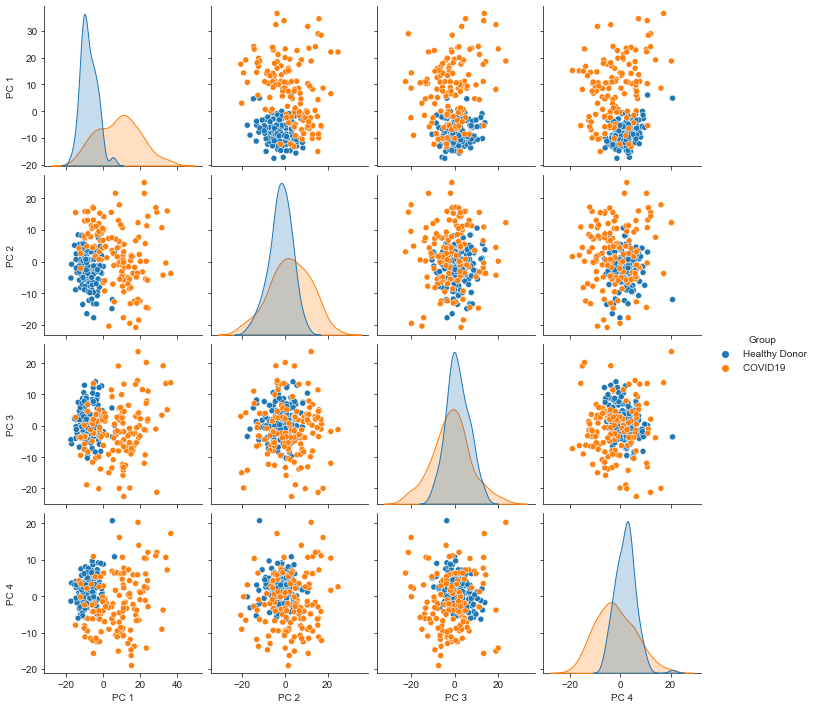

In [5]:
sns.set_style("ticks")
# Perform a 5-component PCA
pca = PCA(n_components=5).fit_transform(covid_data.iloc[:, :-2])
pca_df = pd.DataFrame(pca)
pca_df.columns = ["PC " + str(i) for i in range(1, 6)]
pca_df["Group"] = covid_data["Group"].values
# Use the pairplot function to visualise the transformed data
sns.pairplot(pca_df.iloc[:, np.r_[0:4, 5]],
             hue="Group",
             diag_kind="auto")
plt.show()

The PCA pairplot shows the transformed data from different principal components (PCs) plotted against each other. In this dataset, the strongest separation between the groups is captured by PC1 and PC2.

### Compound identifier conversion
The first step in the pathway analysis workflow is to convert the compound names or identifiers to the identifier type of the pathway database used. In this example, we are using the KEGG database and will be converting componund names to KEGG compound identifiers.

The MetaboAnalyst name conversion tool allows you to convert between several metabolite identifier types and names.
https://www.metaboanalyst.ca/MetaboAnalyst/upload/ConvertView.xhtml

Have a go at converting the compound names of the Su_compound_names.txt file to KEGG ID's. Inspect the results. As there are 900+ compounds profiled in this dataset, just look at a few examples. The full converted dataset is provided below.

<b>What percentage of the compounds in the dataset are you able to map? Which class(es) of compounds are particularly difficult to map?</b>


## Over-representation analysis (ORA)

Over-representation analysis is one of the commonest pathway analysis methods in metabolomics. It tests the null hypothesis that a subset of compounds of interest (e.g. those differentially abundant between study groups) are no more present in a certain biological pathway than background compounds. 

We can build a 2-by-2 contingency table such as the one below, which differentiates between the number of compounds in the dataset which are in a pathway, those that are differentially abundant, and vice versa. A test statistic and P-value can be determined for each pathway using this contingency table by using a one-sided Fisher's exact test. 

<table><tr>
<td> <img src="media/venn_metabolome.png" width="200px">  </td>
<td> <img src="media/ora_contingency_table.png" width="300px">  </td>
</tr></table>

The essential inputs of ORA are:
- Background set (N)
- List of metabolites of interest (n)
- Pathway set (M represents one pathway)

The Venn diagram depicts ORA, in which we are testing the significance of the overlap between the pathway and the compounds of interest, k. 


#### Determining the list of compounds of interest
As input to ORA, we require a list of compounds of interest, which are usually metabolites that are differentially expressed between study groups.
We will obtain this list by using a series of t-tests. 

The function below computes a two-sided t-test for each metabolite in the dataset, testing for a significance in metabolite abundance levels between the COVID and healthy groups. The P-values are then adjusted for multiple-correction testing using the Benjamini-Hochberg FDR method.

In [103]:
def t_tests(matrix, classes, multiple_correction_method, return_stat=False):
    
    """
    Function to perform t-tests between two study groups
    param matrix: processed abundance matrix 
    param classes: column vector (pandas series) with class labels
    param multiple_correction_method: multiple testing correction method 
    (options here: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)
    """
    
    matrix['Target'] = pd.factorize(classes)[0]
    metabolites = matrix.columns.tolist()[:-1]

    pvalues = []
    t_stats = []
    for metabolite in metabolites:
        if isinstance(matrix[matrix['Target'] == 0][metabolite], pd.DataFrame):
            print(metabolite)
            print("duplicate compounds found")
            print(matrix[matrix['Target'] == 0][metabolite])
        group1 = matrix[matrix['Target'] == 0][metabolite].tolist() # Control 
        group2 = matrix[matrix['Target'] == 1][metabolite].tolist() # COVID 
        stat, pval = stats.ttest_ind(group1, group2)
        pvalues.append(pval)
        t_stats.append(stat)
    padj = sm.stats.multipletests(pvalues, 0.05, method=multiple_correction_method)
    if return_stat == True:
        results = pd.DataFrame(zip(metabolites, t_stats, pvalues, padj[1]),
                               columns=["Metabolite", "t-statistic", "P-value", "P-adjust"])
    else:
        results = pd.DataFrame(zip(metabolites, pvalues, padj[1]),
                               columns=["Metabolite", "P-value", "P-adjust"])
    return results

# Use the above function to compute t-tests
t_test_res = t_tests(covid_data_KEGG.iloc[:, :-2], covid_data_KEGG["Group"], "fdr_bh")
# Select differentially abundant metabolites by filtering on the adjusted P-value at ≤ 0.05
DA_metabolites = t_test_res[t_test_res["P-adjust"] < 0.05]["Metabolite"].tolist()

print("There are", len(DA_metabolites), "differentially abundant metabolites in this dataset")

There are 177 differentially abundant metabolites in this dataset


#### Background set
The other essential component of ORA is the background set, or metabolite "universe". Our assay-specific background set consists of all the compounds profiled in our dataset:

In [7]:
# Select all the columns in the data matrix apart from metadata columns (Group and WHO_status)
assay_specific_background_set = covid_data_KEGG.iloc[:, :-2].columns.tolist()
print("The size of the background set is:", len(assay_specific_background_set), "compounds")

The size of the background set is: 243 compounds


#### Running ORA
Now we are ready to perform ORA with KEGG pathways. The function below loops through each pathway in the pathway database and performs a one-sided Fisher's exact test to compute a test statistic and P-value for the enrichment of each pathway.

In [84]:
def over_representation_analysis(DA_list, background_list, pathways_df, filter_empty=True):
    
    """
    Function for over representation analysis using Fisher exact test (right tailed)
    :param DEM_list: List of differentially abundant metabolite IDENTIFIERS
    :param background_list: background list of IDENTIFIERS
    :param pathways_df: pathway dataframe containing compound identifiers
    :return: DataFrame of ORA results for each pathway, p-value, q-value, hits ratio
    """
    
    KEGG_pathways = pathways_df.dropna(axis=0, how='all', subset=pathways_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = dict(zip(pathways, pathway_names))
    KEGG_pathways = KEGG_pathways.drop('Pathway_name', axis=1)

    pathways_with_compounds = []
    pathway_names_with_compounds = []
    pvalues = []
    pathway_ratio = []
    pathway_count = 0
    pathway_coverage = []

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [i for i in pathway_compounds if str(i) != "nan"]
        if filter_empty and (not pathway_compounds or len(pathway_compounds) < 3):
            # ignore pathway if contains no compounds or has less than 3 compounds
            continue
        else:
            pathway_count += 1
            DA_in_pathway = len(set(DA_list) & set(pathway_compounds))
            # k: compounds in DA list AND pathway
            DA_not_in_pathway = len(np.setdiff1d(DA_list, pathway_compounds))
            # K: compounds in DA list not in pathway
            compound_in_pathway_not_DA = len(set(pathway_compounds) & set(np.setdiff1d(background_list, DA_list)))
            # not DEM compounds present in pathway
            compound_not_in_pathway_not_DA = len(np.setdiff1d(np.setdiff1d(background_list, DA_list), pathway_compounds))
            # compounds in background list not present in pathway
            if filter_empty and DA_in_pathway == 0:
                # ignore pathway if there are no DEM compounds in that pathway
                continue
            else:
                # Create 2 by 2 contingency table
                pathway_ratio.append(str(DA_in_pathway) + "/" + str(compound_in_pathway_not_DA + DA_in_pathway))
                pathway_coverage.append(str(compound_in_pathway_not_DA + DA_in_pathway) + "/" + str(len(pathway_compounds)))
                pathways_with_compounds.append(pathway)
                pathway_names_with_compounds.append(pathway_dict[pathway])
                contingency_table = np.array([[DA_in_pathway, compound_in_pathway_not_DA],
                                              [DA_not_in_pathway, compound_not_in_pathway_not_DA]])
                # Run right tailed Fisher's exact test
                oddsratio, pvalue = stats.fisher_exact(contingency_table, alternative="greater")
                pvalues.append(pvalue)
    try:
        padj = sm.stats.multipletests(pvalues, 0.05, method="fdr_bh")
        results = pd.DataFrame(zip(pathways_with_compounds, pathway_names_with_compounds, pathway_ratio, pathway_coverage, pvalues, padj[1]),
                               columns=["Pathway_ID", "Pathway_name", "Hits", "Coverage", "P-value", "P-adjust"])
    except ZeroDivisionError:
        padj = [1] * len(pvalues)
        results = pd.DataFrame(zip(pathways_with_compounds, pathway_names_with_compounds, pathway_ratio, pvalues, padj),
                           columns=["Pathway_ID", "Pathway_name", "Hits", "Coverage", "P-value", "P-adjust"])
    return results

ora_res = over_representation_analysis(DA_metabolites, assay_specific_background_set, KEGG_human_pathways)

Inspect the ORA results. The 'hits' column shows the fraction of DA metabolites present in the pathway (note the pathway is only composed of compounds which are also present in the background set). The 'coverage' column shows the fraction of pathway metabolites in the background list based on the total number of metabolites in a specific KEGG pathway.

In [85]:
# Look at the top 10 pathways ranked by P-value
ora_res.sort_values(by="P-value").head(10)

,Pathway_ID,Pathway_name,Hits,Coverage,P-value,P-adjust
21,hsa00270,Cysteine and methionine metabolism - Homo sapi...,13/14,14/64,0.067838,0.98499
49,hsa00650,Butanoate metabolism - Homo sapiens (human),8/8,8/42,0.075824,0.98499
63,hsa01210,2-Oxocarboxylic acid metabolism - Homo sapiens...,19/22,22/134,0.102479,0.98499
31,hsa00410,beta-Alanine metabolism - Homo sapiens (human),7/7,7/32,0.105262,0.98499
65,hsa01240,Biosynthesis of cofactors - Homo sapiens (human),21/25,25/326,0.136917,0.98499
76,hsa04080,Neuroactive ligand-receptor interaction - Homo...,10/11,11/40,0.150043,0.98499
1,hsa00020,Citrate cycle (TCA cycle) - Homo sapiens (human),5/5,5/20,0.201870,0.98499
30,hsa00400,"Phenylalanine, tyrosine and tryptophan biosynt...",5/5,5/34,0.201870,0.98499
74,hsa04071,Sphingolipid signaling pathway - Homo sapiens ...,5/5,5/15,0.201870,0.98499
45,hsa00600,Sphingolipid metabolism - Homo sapiens (human),4/4,4/25,0.278884,0.98499


<b>What do you think about the level of pathway coverage in this dataset? Would you recommend pathway analysis for datasets with fewer than 100 metabolites profiled?</b>

Let's plot the top 10 pathways ordered by P-value:

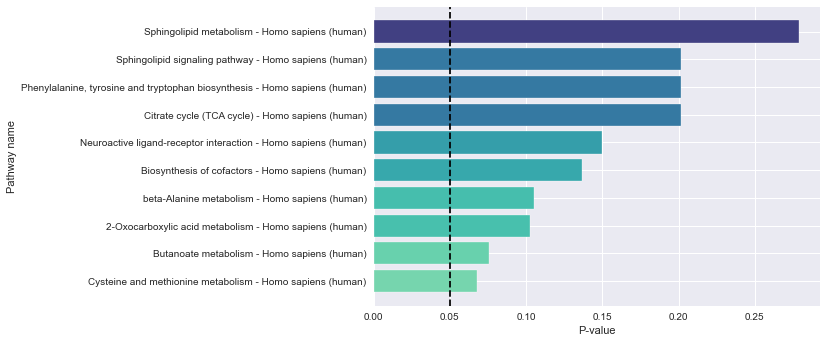

In [86]:
plt.style.use("seaborn")

# we can use a colourmap to colour the bars corresponding to the P-values
cmap = sns.color_palette("mako_r", as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=0.4)
# plot the top 10 pathways
top_10_ora_res = ora_res.sort_values(by="P-value").iloc[0:10, :]
plt.barh(top_10_ora_res["Pathway_name"], top_10_ora_res["P-value"], color=cmap(norm(top_10_ora_res["P-value"])))
plt.xlabel("P-value")
plt.ylabel("Pathway name")
plt.axvline(0.05, color="black", linestyle='--')
plt.show()

#### What happens if we use a non-assay specific background set instead?
This is a common pitfall of metabolomics pathway analysis, and the default background set often consists of all compounds in a pathway database, for example.

Here we will use all KEGG compounds as the non-assay specific background set:

In [88]:
# create the non-specific background set by selecting all the unique compounds mapped to KEGG pathways
non_specific_background_set = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

Now we will perform ORA again with the non-specific background set

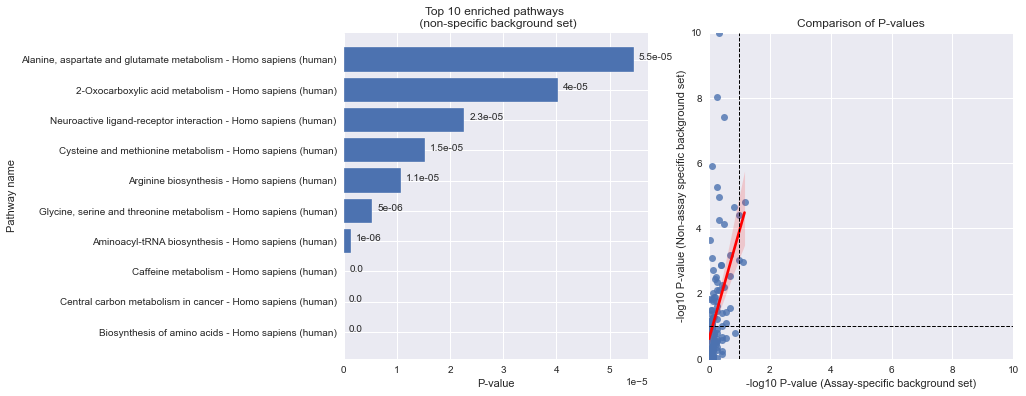

In [89]:
# perform ORA using non-specific background set
ora_res_non_specific_background = over_representation_analysis(DA_metabolites, non_specific_background_set, KEGG_human_pathways)

# plotting code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use("seaborn")
top_10_ora_res_non_specific = ora_res_non_specific_background.sort_values(by="P-value").iloc[0:10, :]
ax1.barh(top_10_ora_res_non_specific["Pathway_name"], top_10_ora_res_non_specific["P-value"])
ax1.set_xlabel("P-value")
ax1.set_ylabel("Pathway name")
ax1.set_title("Top 10 enriched pathways \n (non-specific background set)")

# adding labels for the p-values 
for index, data in enumerate(top_10_ora_res_non_specific["P-value"]):
    ax1.text(data+0.000001, index, s=round(top_10_ora_res_non_specific["P-value"].tolist()[index], 6))
            
intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_non_specific_background["Pathway_ID"].tolist()))
# Ensures pathways are the same in both results (non specific background set can have additional pathways)
ora_res_all = ora_res_non_specific_background.loc[ora_res_non_specific_background["Pathway_ID"].isin(intersect)]
ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
ora_res_all_pvals = np.negative(np.log10(ora_res_non_specific_background["P-value"].tolist()))

sns.regplot(x=ora_res_pvals, y=ora_res_all_pvals, ax=ax2, line_kws={"color": "red"})
ax2.set_ylabel("-log10 P-value (Non-assay specific background set)")
ax2.set_xlabel("-log10 P-value (Assay-specific background set)")
ax2.set_title("Comparison of P-values")
ax2.axhline(y=1, linewidth=1, color='black', linestyle='--')
ax2.axvline(x=1, linewidth=1, color='black', linestyle='--')
ax2.set(ylim=(0, 10), xlim=(0, 10))

plt.show()

In [92]:
# Look at the results of the top 10 enriched pathways using the non-assay-specific background set. 
top_10_ora_res_non_specific

,Pathway_ID,Pathway_name,Hits,Coverage,P-value,P-adjust
64,hsa01230,Biosynthesis of amino acids - Homo sapiens (hu...,27/128,128/128,1.043805e-10,1.523955e-08
143,hsa05230,Central carbon metabolism in cancer - Homo sap...,12/30,30/30,9.362655e-09,6.834738e-07
17,hsa00232,Caffeine metabolism - Homo sapiens (human),10/22,22/22,3.896384e-08,1.896240e-06
60,hsa00970,Aminoacyl-tRNA biosynthesis - Homo sapiens (hu...,13/52,52/52,1.272941e-06,4.646234e-05
20,hsa00260,"Glycine, serine and threonine metabolism - Hom...",12/50,50/50,5.289835e-06,1.544632e-04
15,hsa00220,Arginine biosynthesis - Homo sapiens (human),8/23,23/23,1.074579e-05,2.614809e-04
21,hsa00270,Cysteine and methionine metabolism - Homo sapi...,13/64,64/64,1.524687e-05,3.180062e-04
76,hsa04080,Neuroactive ligand-receptor interaction - Homo...,10/40,40/40,2.263141e-05,4.130233e-04
63,hsa01210,2-Oxocarboxylic acid metabolism - Homo sapiens...,19/134,134/134,4.025083e-05,6.529578e-04
19,hsa00250,"Alanine, aspartate and glutamate metabolism - ...",8/28,28/28,5.450847e-05,7.958237e-04


<b>What do you notice about the P-values obtained using the assay-specific background set as opposed to the non-assay specific background set containing all KEGG compounds?</b>

## Comparing pathway databases
How do pathway analysis results differ when using different pathway databases? Let's compare ORA results obtained using KEGG and Reactome human pathway databases:

In [13]:
ora_KEGG = over_representation_analysis(DA_metabolites, assay_specific_background_set, KEGG_human_pathways)

# First we need to determine differential metabolites for the dataset with Reactome identifiers (ChEBI)
t_test_res_reactome = t_tests(covid_data_CHEBI.iloc[:, :-2], covid_data_CHEBI["Group"], "fdr_bh")
DA_metabolites_reactome = t_test_res_reactome[t_test_res_reactome["P-adjust"] < 0.05]["Metabolite"].tolist()
print(len(DA_metabolites_reactome), "differential metabolites using Reactome with a total background set size of:", len(covid_data_CHEBI.iloc[:, :-2].columns.tolist()))

# Now compute ORA with the Reactome pathways
ora_Reactome = over_representation_analysis(DA_metabolites_reactome, covid_data_CHEBI.iloc[:, :-2].columns.tolist(), Reactome_human_pathways)

245 differential metabolites using Reactome with a total background set size of: 333


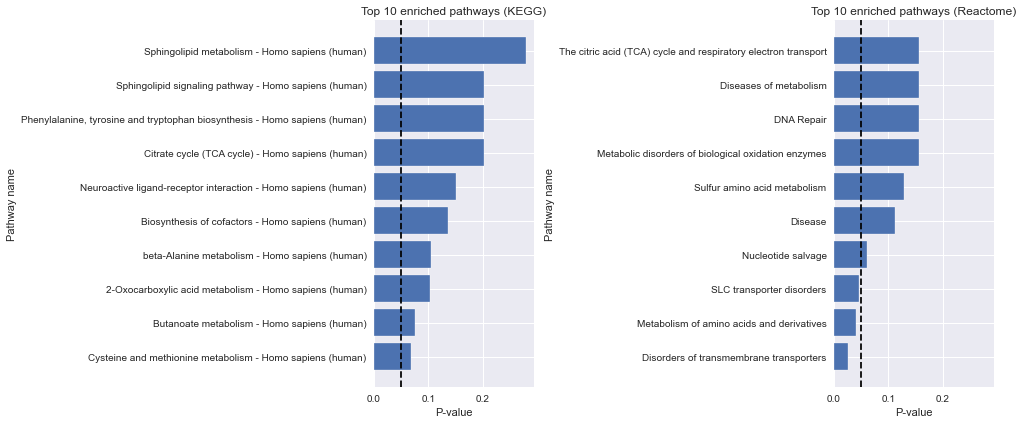

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
plt.style.use("seaborn")
top_10_ora_res_kegg = ora_KEGG.sort_values(by="P-value").iloc[0:10, :]
ax1.barh(top_10_ora_res_kegg["Pathway_name"], top_10_ora_res_kegg["P-value"])
# ax1.set_xticklabels(top_10_ora_res["Pathway_name"], rotation=90)
ax1.set_xlabel("P-value")
ax1.set_ylabel("Pathway name")
ax1.set_title("Top 10 enriched pathways (KEGG)")
ax1.axvline(0.05, color="black", linestyle='--')

top_10_ora_res_reactome = ora_Reactome.sort_values(by="P-value").iloc[0:10, :]
ax2.barh(top_10_ora_res_reactome["Pathway_name"], top_10_ora_res_reactome["P-value"])
# ax2.set_xticklabels(top_10_GSEA_res["pathway_name"], rotation=90)
ax2.set_xlabel("P-value")
ax2.set_ylabel("Pathway name")
ax2.set_title("Top 10 enriched pathways (Reactome)")
plt.tight_layout()
ax2.axvline(0.05, color="black", linestyle='--')

plt.show()

Pathway databases are always evolving, so an important consideration is to use the lastest version of a database when running your analysis. 

## m(GSEA)
Over-representation analysis is a fast and straightforward approach to pathway analysis, but has a few limitations. These include:
- Having to pre-select metabolites of interest (based on a hard threshold such as P-value cutoff)
- Not taking into account the level of differences in these metabolites between study groups (e.g. the fold-change)

Functional class scoring approaches such as gene set enrichment analysis (GSEA)* have been developed to overcome these challenges. They take all measured metabolites as input, which allows small but coordinated changes in the metabolites present in a pathway to be detected. 

Here we will use gseapy to perform this. gseapy can be adapted for metabolomics data simply by using metabolite data and pathways as input. The statistical test and assumptions remain the same. 

First we will create a ranked list of metabolites (based on differences in abundance between COVID and control groups) as input using the t-test function above that we also used to determine the list of metabolites of interest for ORA. We will rank the metabolites based on the t-test statistic. Other common ranking metrics include fold change, or P-value and fold change multiplied together (signed fold-change). 

<sub>*Subramanian A, Tamayo P, Mootha VK, Mukherjee S, Ebert BL, Gillette MA, et al. Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proc Natl Acad Sci U S A. 2005;102: 15545–15550. doi:10.1073/pnas.0506580102</sub>

In [108]:
t_test_res = t_tests(covid_data_KEGG.iloc[:, :-2], covid_data_KEGG["Group"], "fdr_bh", return_stat=True)
ranked_list = t_test_res[["Metabolite", "t-statistic"]]
print(ranked_list)

    Metabolite  t-statistic
0       C03912    -0.457638
1       C00315    -6.911003
2       C14829    -1.409053
3       C05635     1.263461
4       C00026    -3.749653
..         ...          ...
238     C13690    -2.141981
239     C17333     2.631837
240     C05595    -3.977269
241     C08493     5.415387
242     C02370    -2.579308

[243 rows x 2 columns]


Next we will run m(GSEA) using the gseapy package. The inputs for this are:
- The ranked list we just created (in the form of a pandas series)
- A gmt format file containing the pathways (see format details here: https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats)
- The minimum size for a pathway to be included in the analysis

The outputs are stored in the GSEA_Prerank folder

In [97]:
# Run GSEA prerank using our ranked list of metabolites
mgsea_res = gseapy.prerank(rnk=ranked_list,
               gene_sets='KEGG_human_pathways_compounds_R98.gmt',
               min_size=3,
               verbose=True,
               outdir=None) # specify an output directory path if you want to download the full results

2021-06-09 16:29:37,221 Parsing data files for GSEA.............................
2021-06-09 16:29:37,308 0254 gene_sets have been filtered out when max_size=500 and min_size=3
2021-06-09 16:29:37,309 0090 gene_sets used for further statistical testing.....
2021-06-09 16:29:37,310 Start to run GSEA...Might take a while..................
2021-06-09 16:29:38,256 Start to generate gseapy reports, and produce figures...
2021-06-09 16:29:38,268 Congratulations. GSEApy runs successfully................



In [98]:
# Explore the GSEA results in a dataframe

# sort pathways by lowest FDR
mgsea_res_df = mgsea_res.res2d.sort_values(by="fdr").head(10)
# add a column with the full pathway names to the dataframe
mgsea_res_df["pathway_name"] = mgsea_res_df.index.map(dict(zip(KEGG_human_pathways.index, KEGG_human_pathways["Pathway_name"])))
col = mgsea_res_df.pop("pathway_name")
mgsea_res_df.insert(0, "pathway_name", col)

In [99]:
mgsea_res_df.head(10)

,pathway_name,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,,
hsa00232,Caffeine metabolism - Homo sapiens (human),0.723362,2.293791,0.000000,0.000000,22,12,C07130;C16358;C16353;C13747;C16357;C16366;C074...,C07130;C16358;C16353;C13747;C16357;C16366;C074...
hsa00270,Cysteine and methionine metabolism - Homo sapi...,-0.624863,-1.693291,0.008600,0.216264,64,14,C00041;C00097;C02356;C00021;C02291;C00073;C000...,C00021;C02291;C00073;C00022;C00491;C02989;C031...
hsa00564,Glycerophospholipid metabolism - Homo sapiens ...,-0.723283,-1.603477,0.019152,0.225975,55,7,C01233;C00157;C00093;C00114;C00588;C00350;C00346,C00588;C00350;C00346
hsa00061,Fatty acid biosynthesis - Homo sapiens (human),0.739496,1.658324,0.030488,0.263349,56,5,C06424;C02679;C08362;C00249;C01530,C06424;C02679;C08362;C00249;C01530
hsa04071,Sphingolipid signaling pathway - Homo sapiens ...,-0.815126,-1.621887,0.010029,0.274532,15,5,C00836;C00212;C00346;C00319;C06124,C00836;C00212;C00346;C00319;C06124
hsa00360,Phenylalanine metabolism - Homo sapiens (human),-0.588957,-1.479081,0.039795,0.423937,60,12,C01586;C00180;C04148;C00082;C00642;C00022;C001...,C00022;C00122;C07086;C05852;C03519;C00166;C00079
hsa04080,Neuroactive ligand-receptor interaction - Homo...,-0.593743,-1.480796,0.051587,0.499760,40,11,C00037;C00099;C00735;C00780;C00025;C00245;C165...,C00099;C00735;C00780;C00025;C00245;C16512;C002...
hsa00600,Sphingolipid metabolism - Homo sapiens (human),-0.820658,-1.500596,0.028486,0.515728,25,4,C00836;C00346;C00319;C06124,C00346;C00319;C06124
hsa04723,Retrograde endocannabinoid signaling - Homo sa...,-0.676742,-1.430016,0.070323,0.553065,19,6,C00116;C00575;C00157;C00025;C00350;C11695,C00350;C11695


Now we will create some plots to examine the mGSEA results. We can plot the standard GSEA enrichment plot using the gseaplot function:

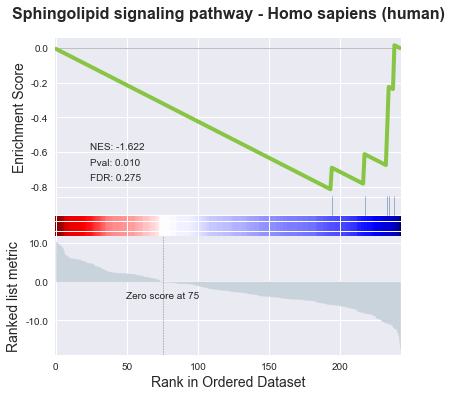

In [100]:
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None

# Here we are plotting the pathway with the lowest FDR, "Sphingolipid signaling pathway - Homo sapiens (human)"
gseaplot(rank_metric=mgsea_res.ranking,
         term="Sphingolipid signaling pathway - Homo sapiens (human)",
         **mgsea_res.results["hsa04071"],
         ofname=None)

<b>What does the m(GSEA) plot show?</b>

The m(GSEA) algorithm walks down the rank-ordered list of metabolites, each time adding a value if a metabolite in the pathway of interest is encountered (the magnitude of this value is based on the correlation of the metabolite with the phenotype (i.e. our t-statistic)), or subtracting a value if a metabolite encountered is not in the pathway of interest. 
- The <b>enrichment score</b> is recorded as the maximum deivation from 0 (i.e. the lowest point on the green curve). In this example the enrichment score is negative. As our ranking metric (t-test statistic) compares the means of the COVID samples relative to the controls, this means that a negative enrichment score suggests that the sphingolipid pathway is enriched in COVID patients. 

- The blue bars at the far right in the middle of the plot indicate <b>where in the ranked metabolite list the metabolites in the pathway appear</b>. If the bars cluster towards the right of the plot, this indicates they appear at the bottom of the ranked metabolite list and the pathway is negatively enriched. Alternatively, if the bars cluster at the left side of the plot, this means the metabolites appear at the top of the ranked list and the pathway is enriched. 

- The bottom part of the plot (ranked list metric) shows how the ranking metric changes as the algorithm walks down the list of genes. A positive ranking metric indicates correlation with the first phenotype (controls), whereas a negative ranking metric indicates a correlation with the second phenotype (COVID).

- The leading edge metabolites (or genes) are those metabolites in the pathway being tested that appear before the maximum deviation from 0 in the case of a positive enrichment score, or after in the case of a negative enrichment score. These are usually the most interesting metabolites in a pathway, as they contribute strongly to the enrichment of the pathway.

Let's compare the top 10 mGSEA results to ORA:

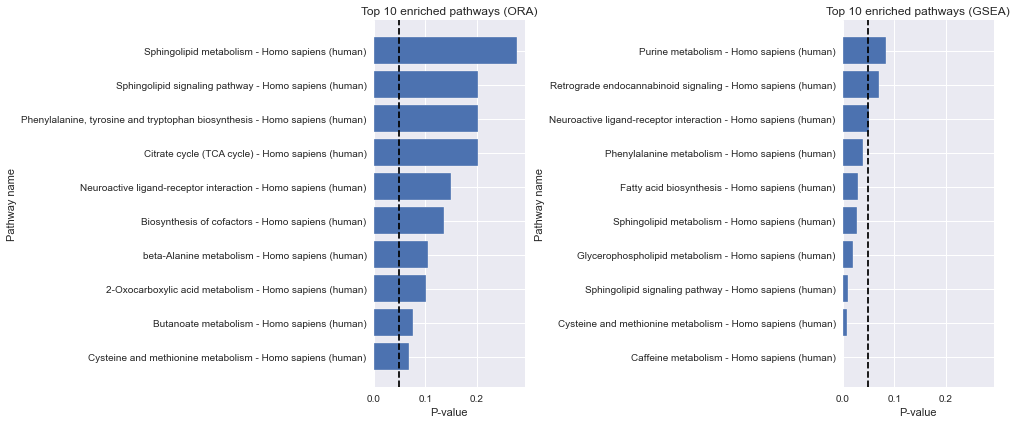

In [101]:
# plotting code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
plt.style.use("seaborn")
top_10_ora_res = ora_res.sort_values(by="P-value").iloc[0:10, :]
ax1.barh(top_10_ora_res["Pathway_name"], top_10_ora_res["P-value"])
ax1.set_xlabel("P-value")
ax1.set_ylabel("Pathway name")
ax1.set_title("Top 10 enriched pathways (ORA)")
ax1.axvline(0.05, color="black", linestyle='--')

top_10_GSEA_res = mgsea_res_df.sort_values(by="pval").iloc[0:10, :]
ax2.barh(top_10_GSEA_res["pathway_name"], top_10_GSEA_res["pval"])
ax2.set_xlabel("P-value")
ax2.set_ylabel("Pathway name")
ax2.set_title("Top 10 enriched pathways (GSEA)")
plt.tight_layout()
ax2.axvline(0.05, color="black", linestyle='--')

plt.show()

### Additional exercise: Using BioPython to visualise pathways
There are many ways to visualise pathways, here is just one example using the BioPython KEGG module


In [70]:
import Bio
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

We can view KEGG pathway diagrams using the Image function:

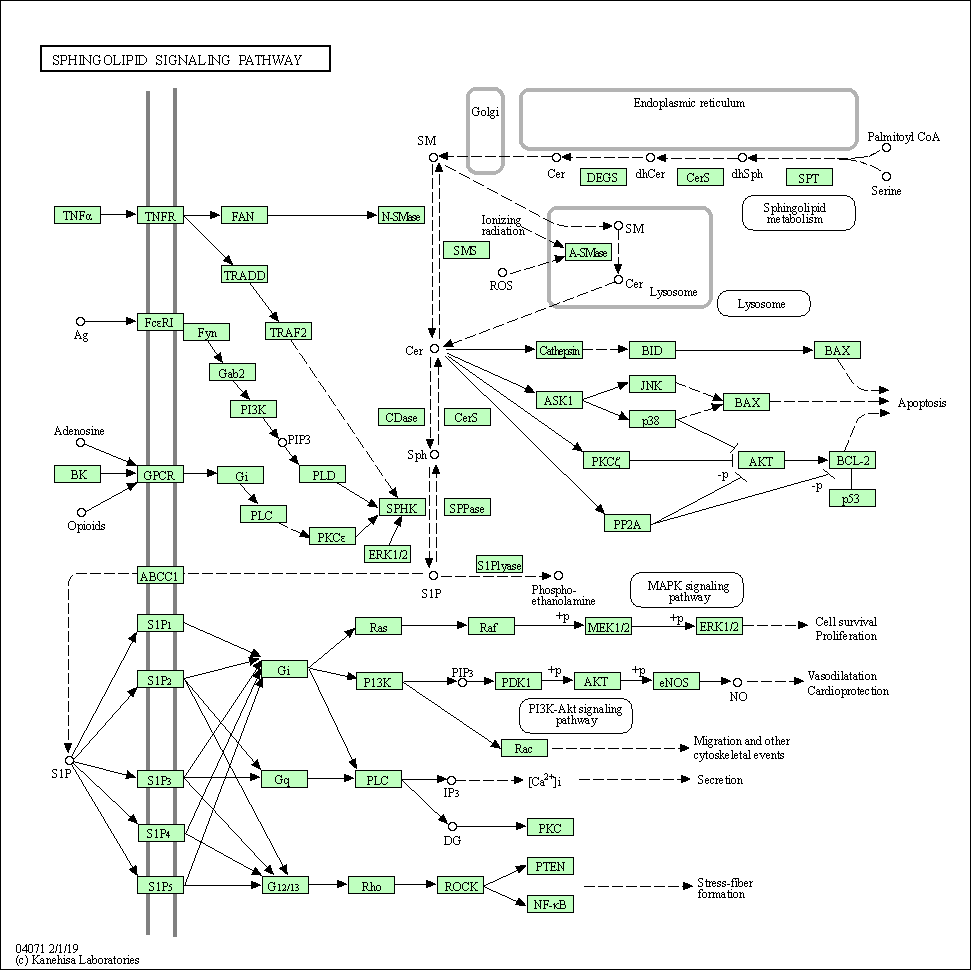

In [71]:
Image(kegg_get("hsa04071", "image").read())

# try replacing "hsa04071" with the name of another KEGG pathway of interest

We can also view additional information about a pathway, such as the number of genes and compounds it contains:

In [72]:
pathway = KGML_parser.read(kegg_get("hsa04071", "kgml"))
print(pathway)

Pathway: Sphingolipid signaling pathway
KEGG ID: path:hsa04071
Image file: https://www.kegg.jp/kegg/pathway/hsa/hsa04071.png
Organism: hsa
Entries: 88
Entry types:
	gene: 63
	compound: 20
	map: 5



The BioPython KGML package allows you to parse KEGG pathway diagrams and add additional features to them. For example, we can highlight the differentially expressed genes present in a pathway:

In [111]:
# If you are getting a 'URLError' please uncomment the following two lines and run the cell again!
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# hsa04071 is the sphingolipid signaling pathway
pathway = KGML_parser.read(kegg_get("hsa04071", "kgml"))
pathway_compounds = [cpd.name for cpd in pathway.compounds]

# We will use the list of differentially abundant compounds we used to perform ORA
DA_metabolites = t_test_res[t_test_res["P-adjust"] < 0.05]["Metabolite"].tolist()
DA_metabolites_kegg_format = ["cpd:"+i for i in DA_metabolites]

# and find which of these compounds are present in the sphingolipid signaling pathway
DA_metabolites_in_pathway = list(set(pathway_compounds) & set(DA_metabolites_kegg_format))
print("There are", len(DA_metabolites_in_pathway), "differentially abundant compounds in the pathway")

# we are highlighting all differentially abundant compounds in red circles
for size, element in zip(range(8, 8+len(pathway.compounds)), pathway.compounds):
    if element.name in DA_metabolites_in_pathway:
        for graphic in element.graphics:
            graphic.width = 20
            graphic.height = 20
            graphic.fgcolor = '#FF0000'
            graphic.bgcolor = '#FF0000'

canvas = KGMLCanvas(pathway,
                    import_imagemap=True,
                    show_genes=False,
                    label_compounds=False,
                    fontsize=14,
                    show_orthologs=False,
                    show_reaction_entries=False,
                    label_maps=False,
                    show_maps=False,
                    draw_relations=True)
# saves the pathway diagram as a pdf in the same folder as the notebook
canvas.draw("pathway_highlighted.pdf")

There are 5 differentially abundant compounds in the pathway


<b>To view the highlighted pathway diagram, see the "pathway_highlighted.pdf" file that has been saved in the same folder as this notebook.</b>
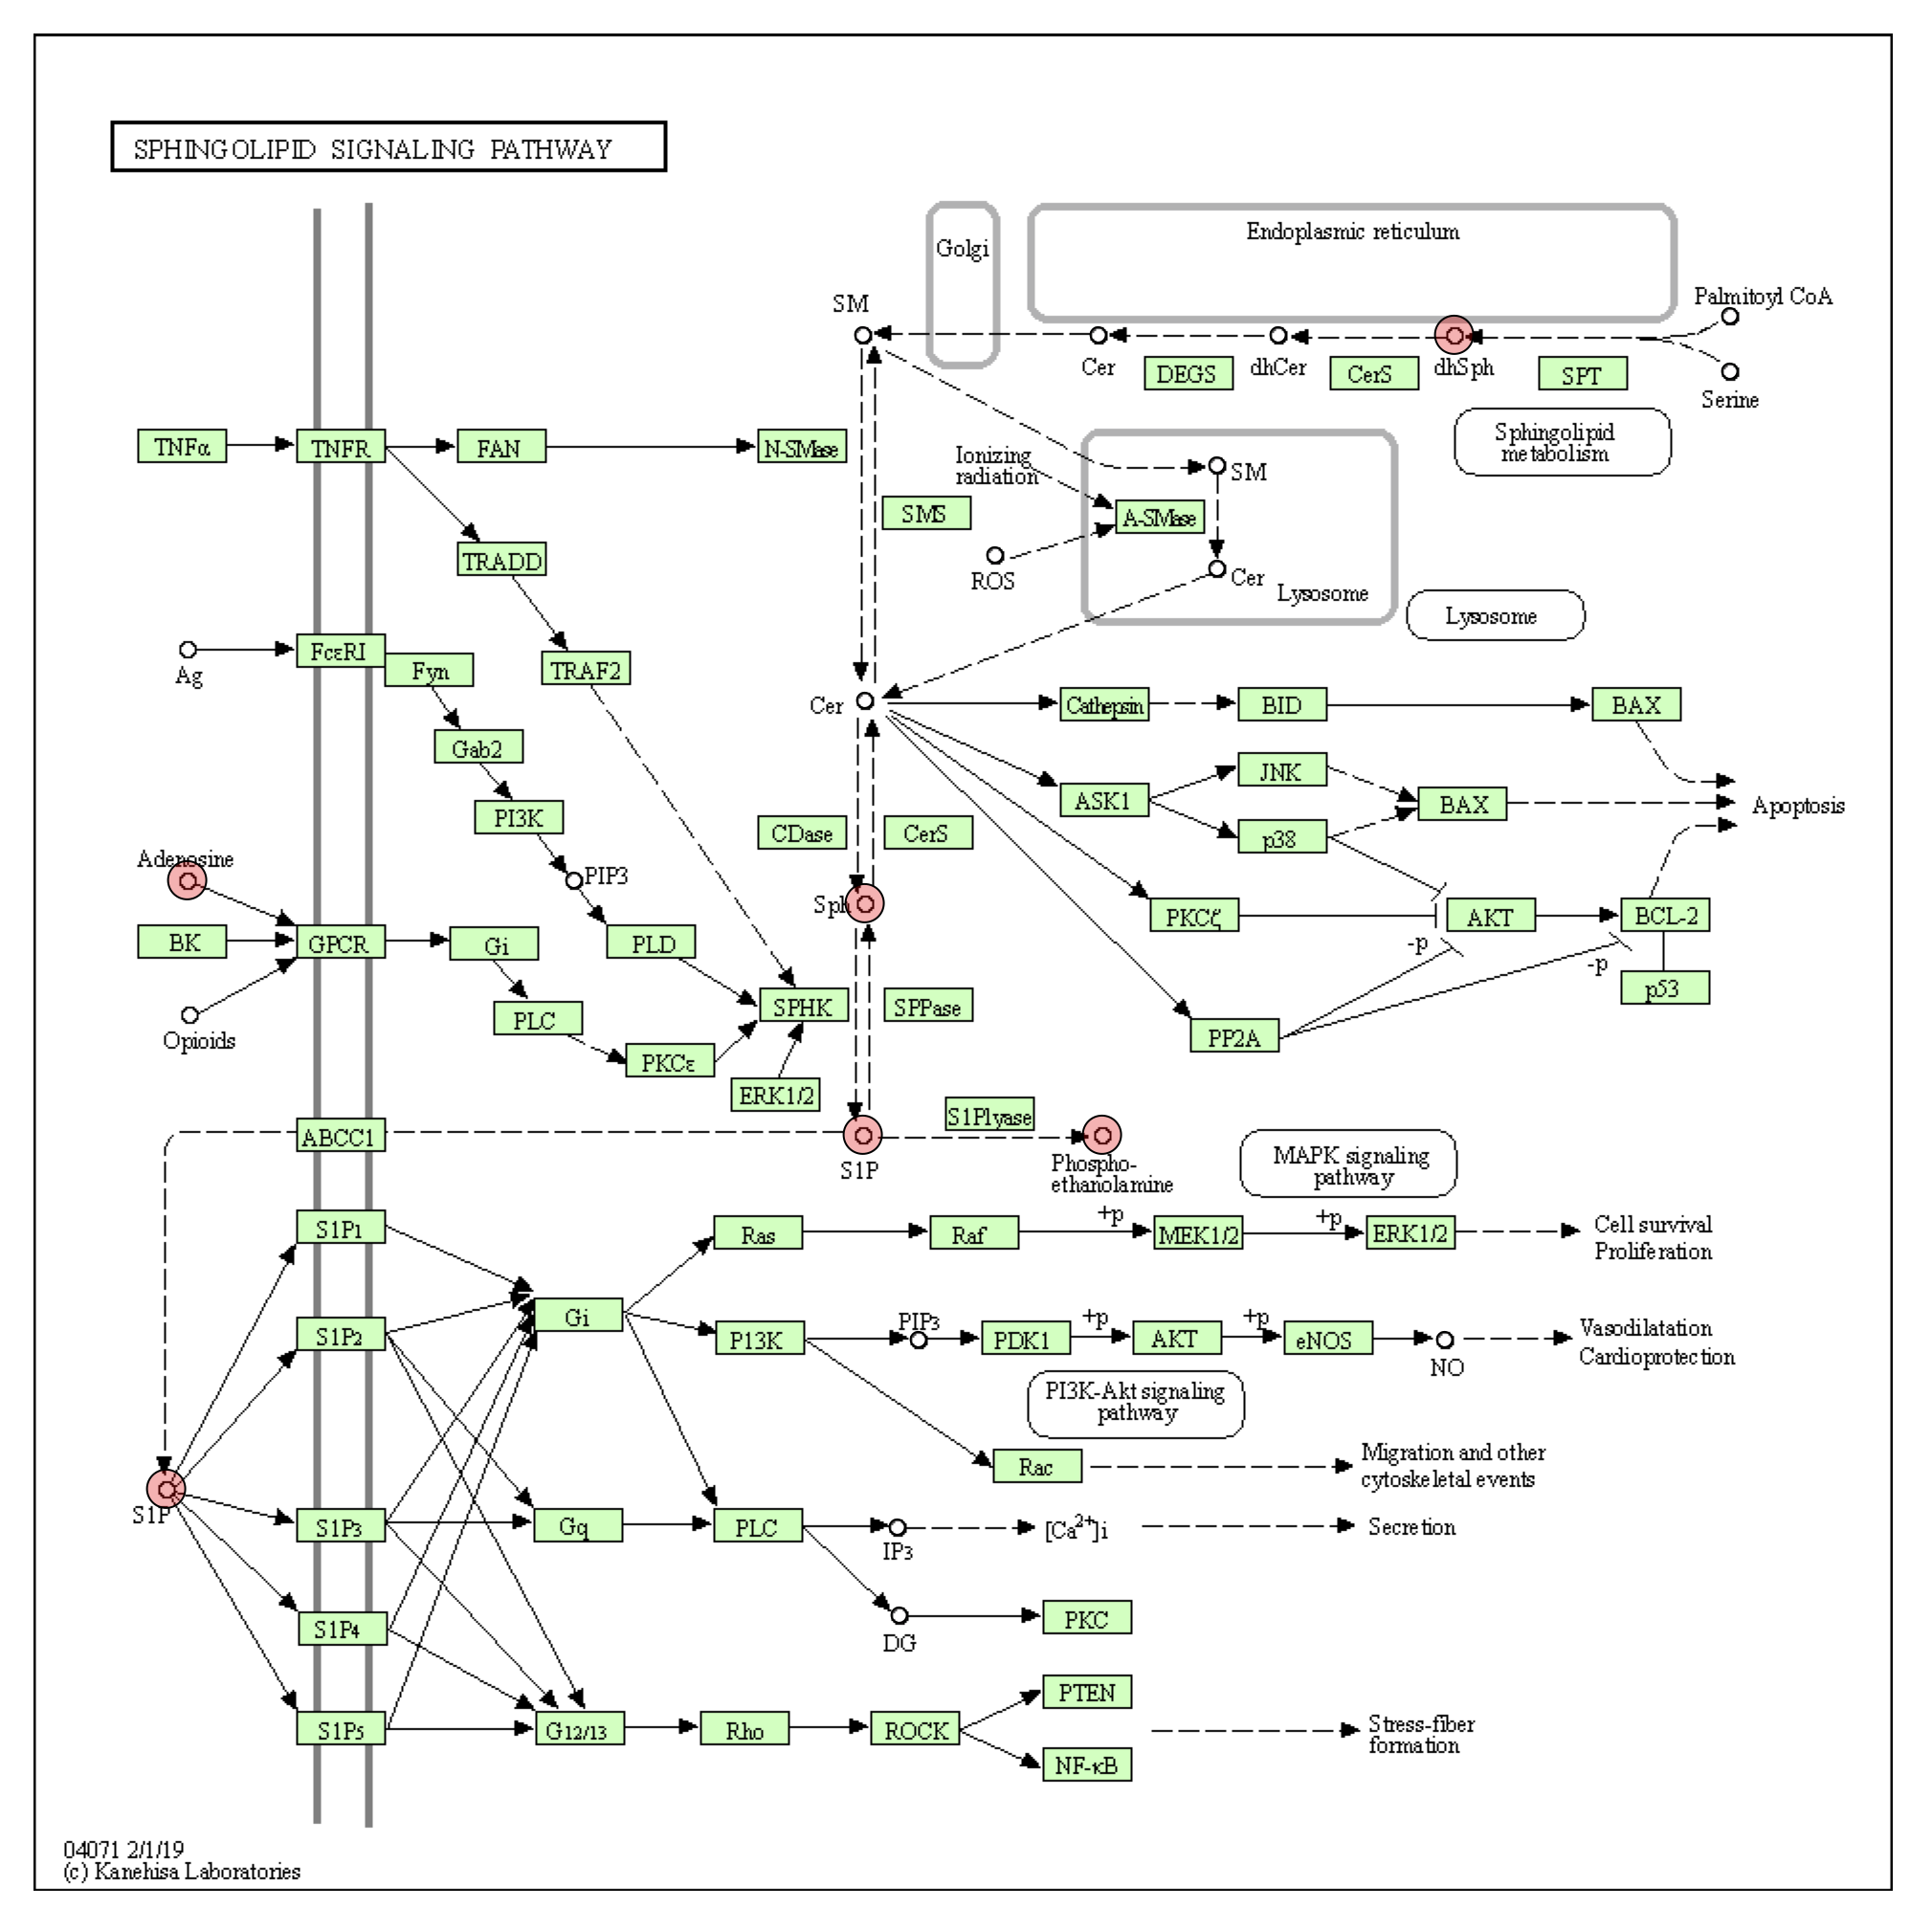

You can also colour the pathways manually by inputting compound IDs and colours to the KEGG search and colour pathway tool: https://www.genome.jp/kegg/tool/map_pathway2.html

### References

The aim of this tutorial was to provide an overview of the most commonly used pathway analysis methods in metabolomics. For a more comprehensive understanding of pathway analysis methods in the field, please refer to the references below.

#### Pathway analysis in metabolomics
1. Wieder C, Frainay C, Poupin N, Rodríguez-Mier P, Vinson F, Cooke J, et al. Pathway analysis in metabolomics: pitfalls and best practice for the use of over-representation analysis. bioRxiv. 2021; 2021.05.24.445406. doi:10.1101/2021.05.24.445406
2. Marco-Ramell A, Palau-Rodriguez M, Alay A, Tulipani S, Urpi-Sarda M, Sanchez-Pla A, et al. Evaluation and comparison of bioinformatic tools for the enrichment analysis of metabolomics data. BMC Bioinformatics. 2018;19: 1. doi:10.1186/s12859-017-2006-0
3. Rosato A, Tenori L, Cascante M, De Atauri Carulla PR, Martins dos Santos VAP, Saccenti E. From correlation to causation: analysis of metabolomics data using systems biology approaches. Metabolomics. Springer New York LLC; 2018. p. 37. doi:10.1007/s11306-018-1335-y
4. Karnovsky A, Li S. Pathway Analysis for Targeted and Untargeted Metabolomics. Methods in Molecular Biology. Humana Press Inc.; 2020. pp. 387–400. doi:10.1007/978-1-0716-0239-3_19

#### General pathway analysis
1. Khatri P, Sirota M, Butte AJ. Ten years of pathway analysis: Current approaches and outstanding challenges. Ouzounis CA, editor. PLoS Computational Biology. Public Library of Science; 2012. p. e1002375. doi:10.1371/journal.pcbi.1002375
2. Mubeen S, Hoyt CT, Gemünd A, Hofmann-Apitius M, Fröhlich H, Domingo-Fernández D. The Impact of Pathway Database Choice on Statistical Enrichment Analysis and Predictive Modeling. Front Genet. 2019;10: 1203. doi:10.3389/fgene.2019.01203
3. Nguyen TM, Shafi A, Nguyen T, Draghici S. Identifying significantly impacted pathways: A comprehensive review and assessment. Genome Biol. 2019;20. doi:10.1186/s13059-019-1790-4

### Useful resources for pathway analysis 
- Pathway commons: integrated pathway database resource which allows for exploration and download of various knowledgebases https://www.pathwaycommons.org/
- KEGG API, can be used to programatically download the KEGG database: https://www.kegg.jp/kegg/rest/keggapi.html
    - Alternatively, KEGGREST in R can be used: http://bioconductor.org/packages/release/bioc/html/KEGGREST.html
- Reactome downloads: https://reactome.org/download-data
- BioCyc pathway database with support for many organisms. Use SmartTables tool to download pathways. https://biocyc.org/

#### Web servers for metabolomics pathway analysis
- MetaboAnalyst 5.0 https://www.metaboanalyst.ca/MetaboAnalyst/ModuleView.xhtml
- Impala http://impala.molgen.mpg.de/
- MetExplore https://metexplore.toulouse.inrae.fr/index.html/
- MetScape http://metscape.ncibi.org/
- Reactome over-representation analysis https://reactome.org/PathwayBrowser/#TOOL=AT
- PaintOmics, multi-omics pathway visualisation tool http://www.paintomics.org/

#### R tools for pathway analysis
- fast GSEA, can be used for metabolomics data https://bioconductor.org/packages/release/bioc/html/fgsea.html
- ClusterProfiler pathway analysis and visualisation tool http://yulab-smu.top/clusterProfiler-book/
- FELLA, R package for metabolomics enrichment using KEGG https://github.com/b2slab/FELLA

#### Python tools for pathway analysis 
- BioServices, can be used to convert between compound identifiers https://bioservices.readthedocs.io/en/master/compound_tutorial.html
- Pathway analysis toolkit https://github.com/iseekwonderful/PyPathway
- GSEAPy https://gseapy.readthedocs.io/en/latest/introduction.html


Questions? Contact cw2019@ic.ac.uk